신경 단어 벡터 시각화를 사용해 고차원의 단어를 2차원으로 시각화

In [1]:
from __future__ import print_function
import os

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.stem import PorterStemmer

import string
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
def preprocessing(text): # 텍스트 전처리 함수
    text2 = " ".join("".join([" " if ch in string.punctuation else ch for ch in text]).split())
    tokens = [word for sent in nltk.sent_tokenize(text2) for word in nltk.word_tokenize(sent)]
    tokens = [word.lower() for word in tokens]
    
    stopwds = stopwords.words('english')
    tokens = [token for token in tokens if token not in stopwds]
    tokens = [word for word in tokens if len(word)>=3]
    
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    tagged_corpus = pos_tag(tokens)    
    
    Noun_tags = ['NN','NNP','NNPS','NNS']
    Verb_tags = ['VB','VBD','VBG','VBN','VBP','VBZ']

    lemmatizer = WordNetLemmatizer()

    def prat_lemmatize(token,tag):
        if tag in Noun_tags:
            return lemmatizer.lemmatize(token,'n')
        elif tag in Verb_tags:
            return lemmatizer.lemmatize(token,'v')
        else:
            return lemmatizer.lemmatize(token,'n')
    
    pre_proc_text =  " ".join([prat_lemmatize(token,tag) for token,tag in tagged_corpus])             

    return pre_proc_text

In [3]:
fin = open("/content/drive/MyDrive/Colab Notebooks/12주차_과제_김정웅(20175308)/alice_in_wonderland.txt", "rb")
lines = []
for line in fin:
    line = line.strip().decode("ascii", "ignore")
    
    if len(line) == 0:
        continue
    lines.append(preprocessing(line))
fin.close()


In [4]:
import collections
counter = collections.Counter()

for line in lines:
    for word in nltk.word_tokenize(line):
        counter[word.lower()]+=1

word2idx = {w:(i+1) for i,(w,_) in enumerate(counter.most_common())}        
idx2word = {v:k for k,v in word2idx.items()}

In [5]:
!pip install nltk==3.4

In [14]:
xs = []
ys = []
for line in lines:
    embedding = [word2idx[w.lower()] for w in nltk.word_tokenize(line)] 
    triples = list(nltk.trigrams(embedding))
    w_lefts = [x[0] for x in triples]
    w_centers = [x[1] for x in triples]
    w_rights = [x[2] for x in triples]
    xs.extend(w_centers)
    ys.extend(w_lefts)
    xs.extend(w_centers)
    ys.extend(w_rights)
print (len(word2idx))

vocab_size = len(word2idx)+1
print(vocab_size)

1786
1787


In [18]:
ohe = OneHotEncoder(categories=[range(vocab_size)])
X = ohe.fit_transform(np.array(xs).reshape(-1, 1)).todense()
Y = ohe.fit_transform(np.array(ys).reshape(-1, 1)).todense()
Xtrain, Xtest, Ytrain, Ytest,xstr,xsts = train_test_split(X, Y,xs, test_size=0.3,
                                                random_state=42)
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)

(9707, 1787) (4161, 1787) (9707, 1787) (4161, 1787)


In [19]:
from keras.layers import Input,Dense,Dropout
from keras.models import Model

np.random.seed(42)
BATCH_SIZE = 128
NUM_EPOCHS = 20

input_layer = Input(shape = (Xtrain.shape[1],),name="input")
first_layer = Dense(300,activation='relu',name = "first")(input_layer)
first_dropout = Dropout(0.5,name="firstdout")(first_layer)

second_layer = Dense(2,activation='relu',name="second")(first_dropout)

third_layer = Dense(300,activation='relu',name="third")(second_layer)
third_dropout = Dropout(0.5,name="thirdout")(third_layer)

fourth_layer = Dense(Ytrain.shape[1],activation='softmax',name = "fourth")(third_dropout)


history = Model(input_layer,fourth_layer)
history.compile(optimizer = "rmsprop",loss="categorical_crossentropy",metrics=["accuracy"])

history.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE,epochs=NUM_EPOCHS, verbose=1,validation_split = 0.2)

Epoch 1/20
61/61 [==============================] - 3s 39ms/step - loss: 6.8958 - accuracy: 0.0406 - val_loss: 6.4385 - val_accuracy: 0.0479
Epoch 2/20
61/61 [==============================] - 2s 35ms/step - loss: 6.3955 - accuracy: 0.0429 - val_loss: 6.4426 - val_accuracy: 0.0479
Epoch 3/20
61/61 [==============================] - 2s 35ms/step - loss: 6.3470 - accuracy: 0.0439 - val_loss: 6.4705 - val_accuracy: 0.0479
Epoch 4/20
61/61 [==============================] - 2s 35ms/step - loss: 6.3252 - accuracy: 0.0438 - val_loss: 6.4999 - val_accuracy: 0.0479
Epoch 5/20
61/61 [==============================] - 2s 36ms/step - loss: 6.3093 - accuracy: 0.0433 - val_loss: 6.5280 - val_accuracy: 0.0479
Epoch 6/20
61/61 [==============================] - 2s 36ms/step - loss: 6.2943 - accuracy: 0.0440 - val_loss: 6.5586 - val_accuracy: 0.0479
Epoch 7/20
61/61 [==============================] - 2s 35ms/step - loss: 6.2840 - accuracy: 0.0440 - val_loss: 6.5546 - val_accuracy: 0.0479
Epoch 8/20
61

In [20]:
encoder = Model(history.input,history.get_layer("second").output)

reduced_X = encoder.predict(Xtest)

final_pdframe = pd.DataFrame(reduced_X)
final_pdframe.columns = ["xaxis","yaxis"]
final_pdframe["word_indx"] = xsts
final_pdframe["word"] = final_pdframe["word_indx"].map(idx2word)

In [23]:
rows = random.sample(list(final_pdframe.index), 100)
vis_df = final_pdframe.loc[rows]

labels = list(vis_df["word"])
xvals = list(vis_df["xaxis"])
yvals = list(vis_df["yaxis"])

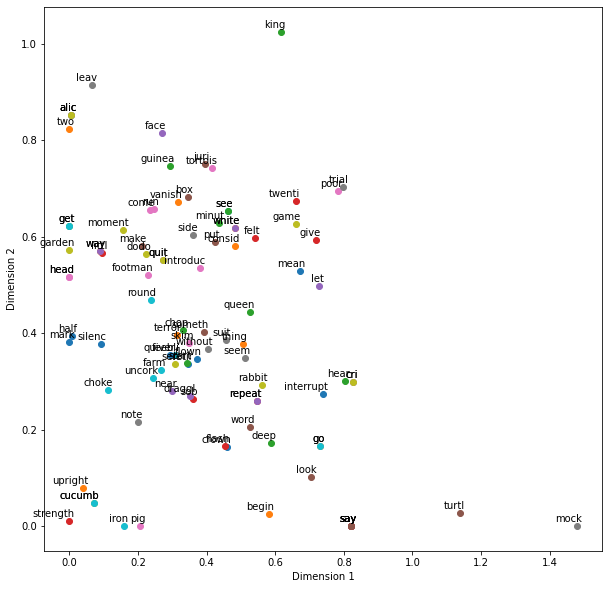

In [24]:
# 고차원의 임베딩 벡터를 가진 단어들의 2차원 축소를 통해 시각화 가능
plt.figure(figsize=(10, 10))  

for i, label in enumerate(labels):
    x = xvals[i]
    y = yvals[i]
    plt.scatter(x, y)
    plt.annotate(label,xy=(x, y),xytext=(5, 2),textcoords='offset points',
                 ha='right',va='bottom')

plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()